legi: 23-911-779

# SLT-CE-3: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [264]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker, colormaps

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [2]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [3]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

In [330]:
base = colormaps['Spectral']
color_list = base(np.linspace(0, 1, 42))
CMAP42 = base.from_list('', color_list, 42)

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [66]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self, Delta=2.6):
        self.PMAT = None
        self.S = None
        self.D = None
        self.Delta = Delta
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        self.S = np.exp(-shortest_path(PMAT)/self.Delta)
        np.fill_diagonal(self.S, 1)
        self.D = 1 - self.S
    

        Ds = (self.D + self.D.T)/2
        Q = np.identity(NUM_NODES) - 1/NUM_NODES
        Dc = Q @ Ds @ Q
        Sc = -Dc/2
        
        vals, V = np.linalg.eig(Sc)
        l_min = np.min(vals)
        S_tilde = Sc - l_min
        vals -= l_min
        
        idx = np.flip(np.argsort(vals))
        self.eigenvalues = vals[idx]
        
        self.V = V[:, idx]
        self.L = np.diag(self.eigenvalues)
    
        self.X = (self.V @ np.sqrt(self.L)).T
                
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        self.Vp = self.V[:,0:p]
        self.Lp = self.L[0:p,0:p]
        self.Xp = (self.Vp @ np.sqrt(self.Lp))
        
        return self.Xp
        


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: 

Given is a proximity matrix $D \in \mathbb{R}^{n\times n}$ (such that diagonal elements are zero) on which we wish to perform pairwise clustering. The goal of CSE is to embedded the data into euclidean space, i.e. find vectors $x_i \in \mathbb{R}^n$ (for $i =1,\dots ,n$) such that $\tilde D_{ij} = ||x_i - x_j||$, where $\tilde D$ is a suitably transformed and equivalent version of $D$, in the sense that
$$
H^{pc}(\tilde D) = H^{pc}(D) + \text {const.}, \tag{1}
$$
where 
$$
H^{pc}(D) = \frac{1}{2}\sum_{\nu \leq k} \frac{\sum_{i,j \leq n}M_{i\nu}M_{j\nu}D_{ij}}{\sum_{l\leq n}M_{l\nu}}
$$
is the pairwise clustering cost function corresponding to a binary assignment matrix $M \in \{0,1\}^{n\times k}$ with $\sum_{\nu \leq k}M_{i\nu} = 1$ for $i = 1, \ldots ,n$. The paper propses to find matrices $\tilde D$ and $X^\top := \begin{pmatrix} \mid &  & \mid \\ x_1 & \cdots & x_n \\ \mid & & \mid \end{pmatrix}$
by the following algorithm (where is $D$ WLOG symmetrical):

1. Decompose $D$: Find a matrix $S \in \mathbb{R}^{n\times n}$ such that $D_{ij} = S_{ii} + S_{jj} - 2S_{ij}$ (for $i, j = 1, \dots , n$).

2. Centralize $S$: Set $S^c= QSQ$, where $Q = I_n - \frac{1}{n}e_ne_n^\top$.

3. Make positive semi-definite by diagonal shift: Set $\tilde S = S^c - I_n\lambda_{\text{min}}$, where $\lambda_\text{min} := \min \{\lambda : \lambda \text{ is an eigenvalue for } S^c\}$

4. Take square-root: Since $\tilde S$ is positive semi-definite, there exists a matrix $X \in \mathbb{R}^{n\times n}$ such that $\tilde S = XX^\top$, namely $X = V\Lambda^{1/2}$, with $V= \begin{pmatrix} \mid &  & \mid \\ v_1 & \cdots & v_n \\ \mid & & \mid \end{pmatrix}$ and $\Lambda^{1/2} = \text{diag} ( \sqrt\lambda_1, \dots, \sqrt\lambda_n)$, where $\lambda_i$ are the eigenvalues of $\tilde S$ in decreasing order and $v_i \in \mathbb{R}^n$ are the corresponding eigenvectors, for $i = 1,\dots, n$.
5. Retrieve $\tilde D$: Calculate entries in the transformed matrix by $\tilde D_{ij} = \tilde S_{ii} + \tilde D_{jj} - 2\tilde S_{ij}$.

One can perform dimensionality reduction by only using a subset of the eigenvectors in $V$. That is, by taking $X_p = V_p \Lambda_p^{1/2}$, where $V= \begin{pmatrix} \mid &  & \mid \\ v_1 & \cdots & v_p \\ \mid & & \mid \end{pmatrix}$ and $\Lambda^{1/2} = \text{diag} ( \sqrt\lambda_1, \dots, \sqrt\lambda_p)$ for $p \leq n$.

<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [67]:
CSE = ConstantShiftEmbedding()


<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [68]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

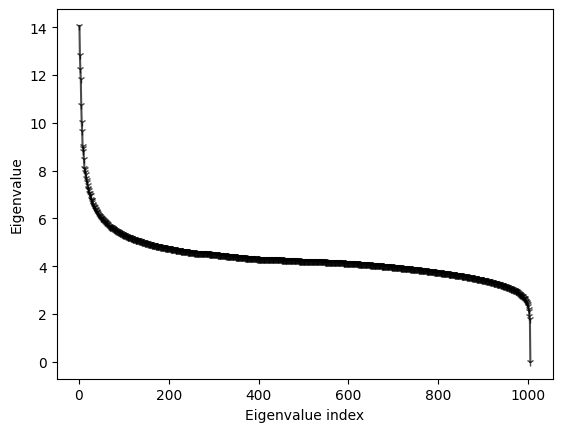

In [69]:
## Compute eigen-spectrum
plt.plot(np.arange(1, NUM_NODES+1), CSE.eigenvalues, '1-', color='k', alpha=0.7)
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.show()

The eigenvalues dop quite drastically before approximately $\lambda =$ 15, before plateauing. This indicates that the eigenvalues larger than to 15 carry the lion's share of the information.

In [70]:
## Determine a good cut-off value (and write some lines to explain your choice)

lambda_p = 6
p_opt = np.where(CSE.eigenvalues > lambda_p)[0][-1]  ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  50


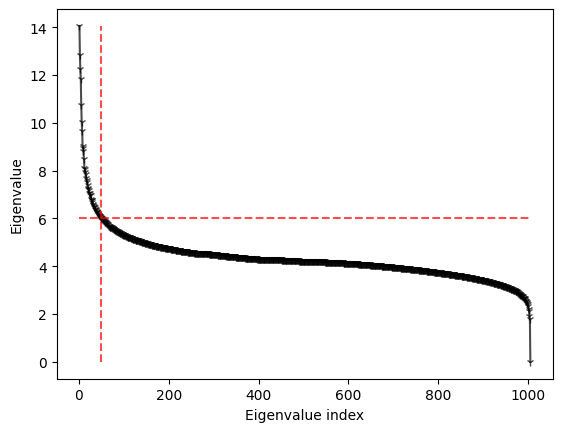

In [71]:
## Plot spectrum and indicate the cut-off value on the spectrum

plt.plot(np.arange(1, NUM_NODES+1), CSE.eigenvalues, '1-', color='k', alpha=0.7)
plt.plot(np.arange(1, NUM_NODES+1), np.ones(NUM_NODES)*lambda_p, '--', color='r', alpha=0.7)
plt.plot([p_opt, p_opt], [CSE.eigenvalues.min(), CSE.eigenvalues.max()], '--', color='r', alpha=0.7)
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.show()


<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [72]:
from sklearn.cluster import KMeans

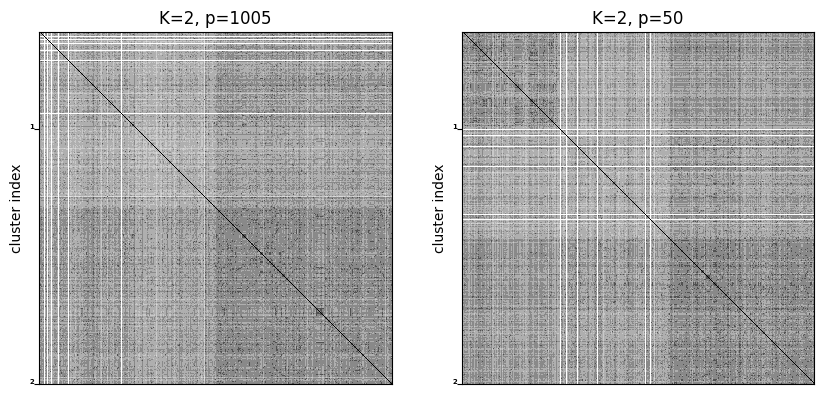

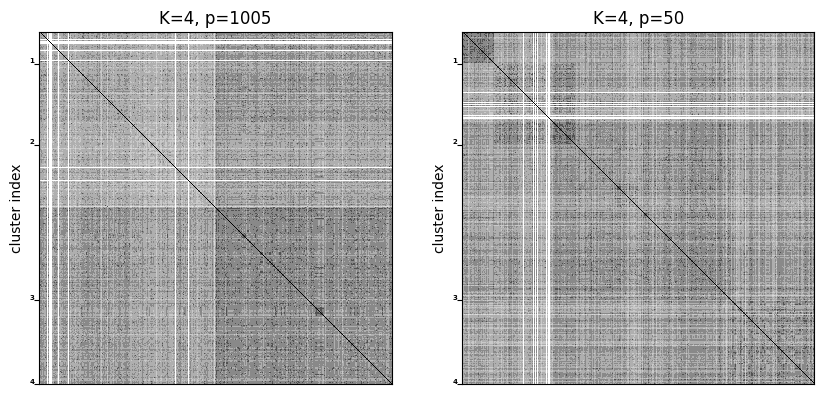

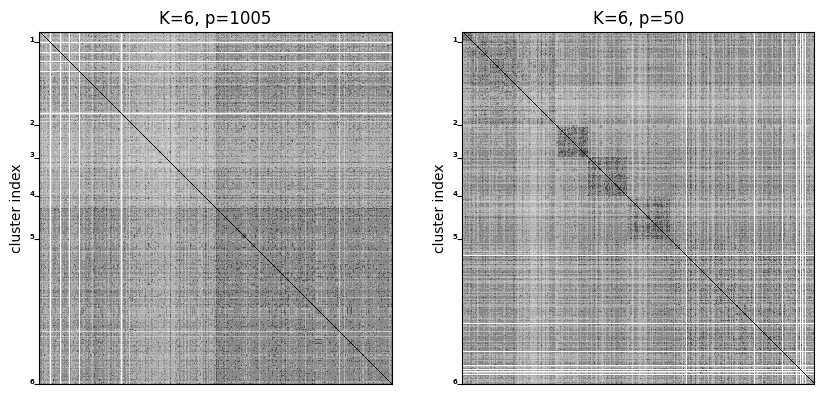

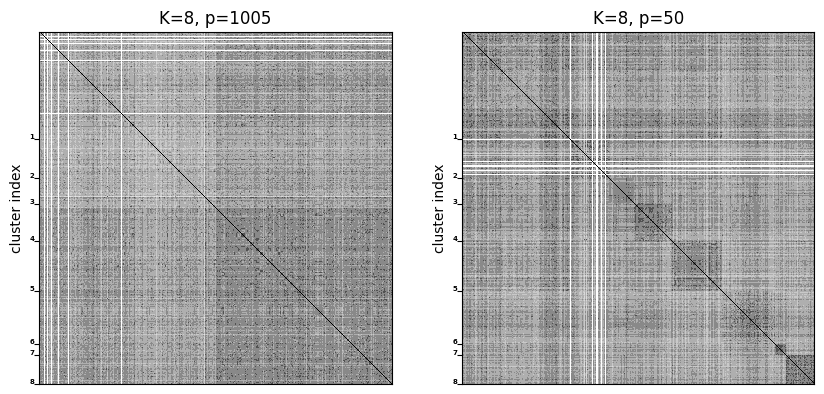

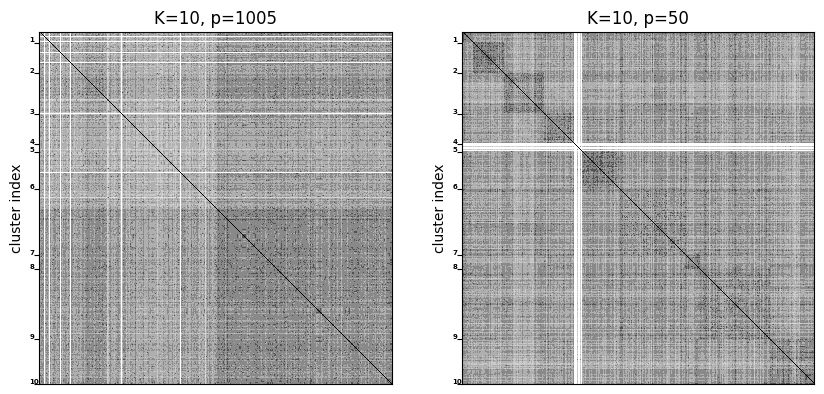

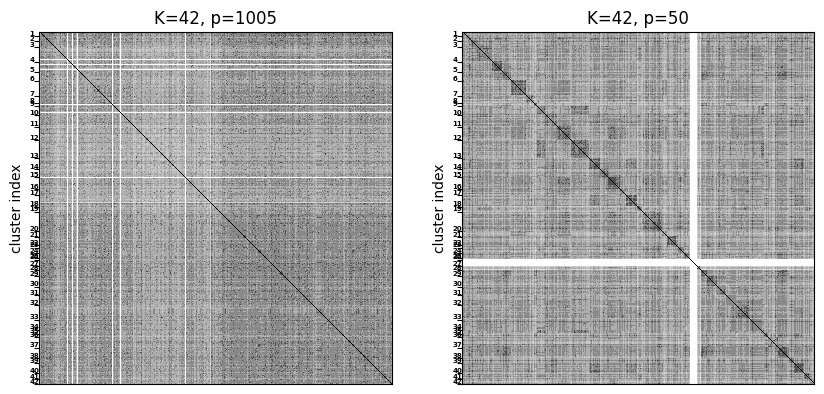

In [73]:
## Distance matrices
X = CSE.X
Xp = CSE.get_embedded_vectors(p_opt)

for K in [2, 4, 6, 8, 10, 42]:
    KM = KMeans(n_clusters=K, n_init=10, random_state=42)
    clusters = KM.fit_predict(X)
    idx = np.argsort(clusters)
    D = CSE.D[idx, :][:, idx]
        
    clusters = KM.fit_predict(Xp)
    idx = np.argsort(clusters)
    clusters = clusters[idx]
    Dp = CSE.D[idx, :][:, idx]
    
    plt.figure(figsize=(10,20))    

    plt.subplot(121)
    plt.matshow(D, cmap=plt.cm.gray, fignum=False)
    plt.xticks([])
    plt.yticks(np.concatenate((np.where((clusters - np.roll(clusters, 1)) > 0)[0],[NUM_NODES])), labels=np.arange(1,K+1), va='bottom', ha='left')
    plt.yticks(fontsize=5, fontweight='bold')
    plt.ylabel('cluster index')
    plt.title(f'K={K}, p={NUM_NODES}')    
    plt.subplot(122)
    plt.matshow(Dp, cmap=plt.cm.gray, fignum=False)
    plt.xticks([])
    plt.yticks(np.concatenate((np.where((clusters - np.roll(clusters, 1)) > 0)[0],[NUM_NODES])), labels=np.arange(1,K+1), va='bottom', ha='left')
    plt.yticks(fontsize=5, fontweight='bold')
    plt.ylabel('cluster index')
    plt.title(f'K={K}, p={p_opt}')
    plt.show()
    
    

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

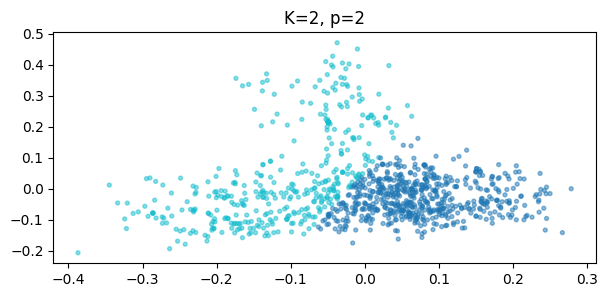

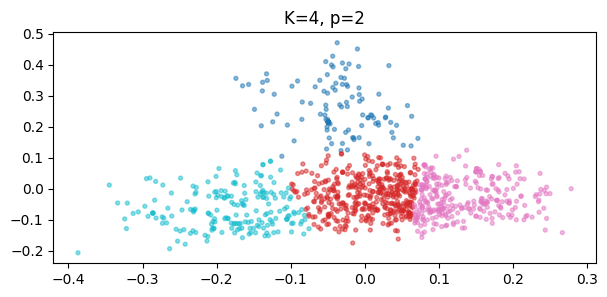

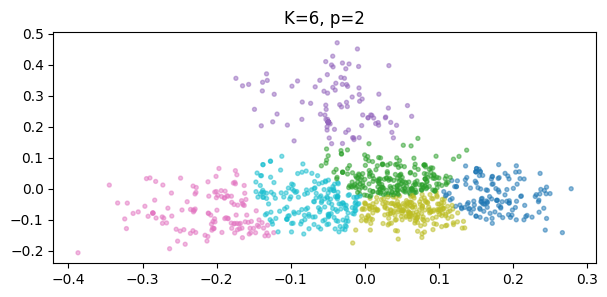

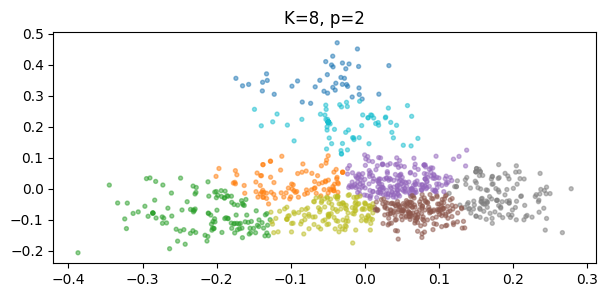

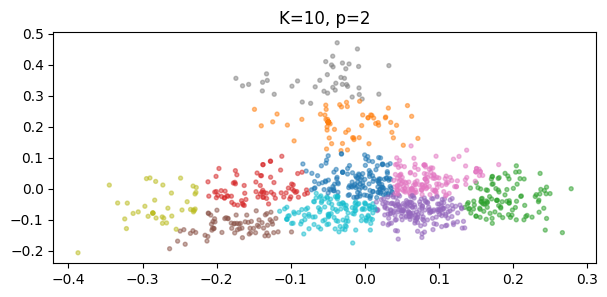

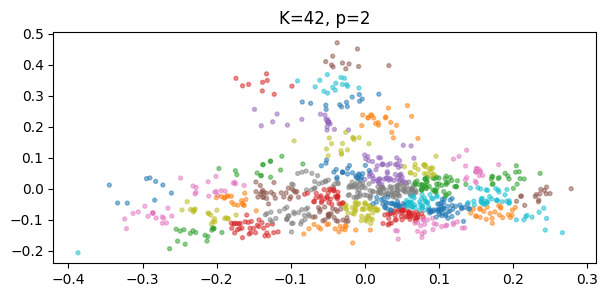

In [323]:
## Get embeddings, run K-MEANS and generate plots

## Distance matrices
p = 2
Xp = CSE.get_embedded_vectors(p)

for K in [2, 4, 6, 8, 10, 42]:
    
    KM = KMeans(n_clusters=K, n_init=10, random_state=42)
    clusters = KM.fit_predict(Xp)
    
    plt.figure(figsize= (7, 3))
    
    plt.scatter(Xp[:, 0], Xp[:,1], c=clusters, alpha=0.5, cmap='tab10', s=8)
    plt.title(f'K={K}, p={p}')
    plt.show()
    

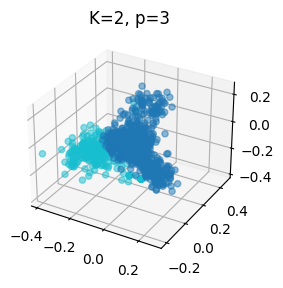

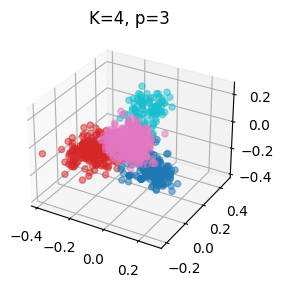

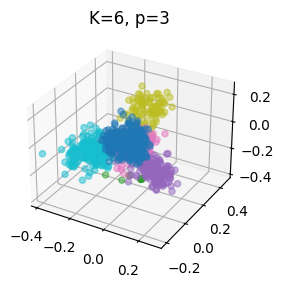

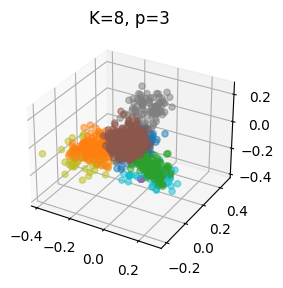

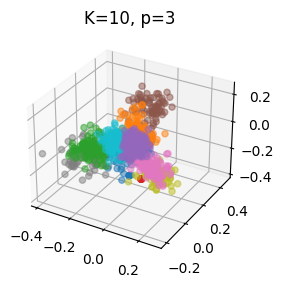

In [321]:
p = 3
Xp = CSE.get_embedded_vectors(p)

for K in [2, 4, 6, 8, 10]:
    
    KM = KMeans(n_clusters=K, n_init=10, random_state=42)
        
    clusters = KM.fit_predict(Xp) 
    
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(Xp[:, 0], Xp[:,1], Xp[:,2], c=clusters, alpha=0.5, cmap='tab10')
    ax.set_title(f'K={K}, p={p}')

    plt.show()

In [76]:
from sklearn.manifold import TSNE

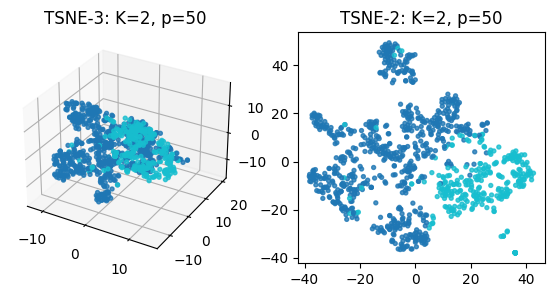

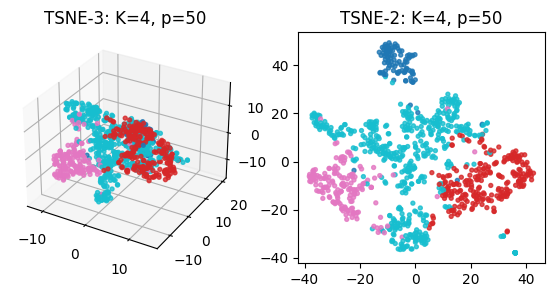

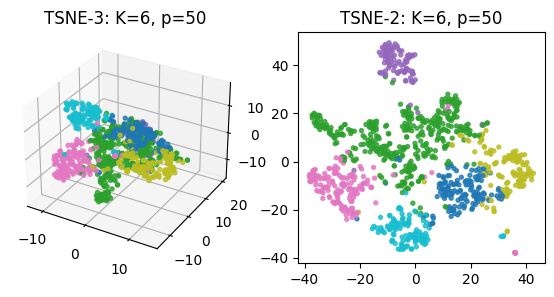

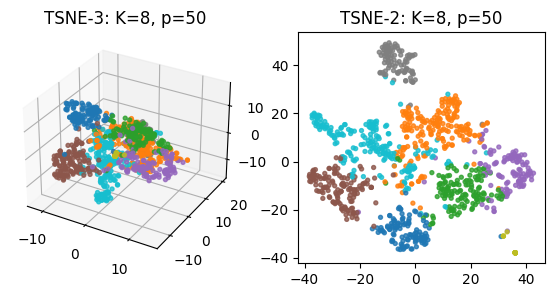

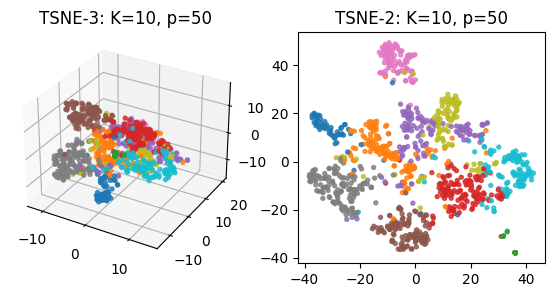

In [320]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else

Xp = CSE.get_embedded_vectors(10)

X2 = TSNE(n_components=2).fit_transform(Xp)
X3 = TSNE(n_components=3).fit_transform(Xp)

for K in [2, 4, 6, 8, 10]:
    
    
    KM = KMeans(n_clusters=K, n_init=10, random_state=42)
    clusters = KM.fit_predict(Xp) 
    
    
    fig = plt.figure(figsize=(7, 3))
    
    plt.subplot(121)
    sc = plt.scatter(X2[:,0], X2[:,1], c=clusters, alpha =0.8, s=8, cmap="tab10")
    plt.title(f'TSNE-2: K={K}, p={p_opt}')   
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(X3[:, 0], X3[:,1], X3[:,2], c=clusters, alpha=0.8, s=8,  cmap="tab10")
    plt.title(f'TSNE-3: K={K}, p={p_opt}')

         
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [78]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [80]:
Xp = CSE.get_embedded_vectors(p_opt)
KM = KMeans(n_clusters=42, random_state=42, n_init=10)
clusters = KM.fit_predict(Xp)

In [81]:
def match_clusters(true, pred):
    
    n_clusters = np.size(np.unique(pred))
    C = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            C[i, j] = np.sum((true == j) != (pred == i))
            
    _, assignment = linear_sum_assignment(C)
    matched = np.array([assignment[c] for c in pred])
    
    return matched

In [127]:
CSE = ConstantShiftEmbedding()
CSE.fit(DATA)
Xp = CSE.get_embedded_vectors(p_opt)
KM = KMeans(n_clusters=42, random_state=42, n_init=10)
clusters = KM.fit_predict(Xp)
matched = match_clusters(AFFILIATIONS, clusters)
acc = accuracy_score(AFFILIATIONS, matched)
print("Accuracy: ", round(acc, 3))

Accuracy:  0.57


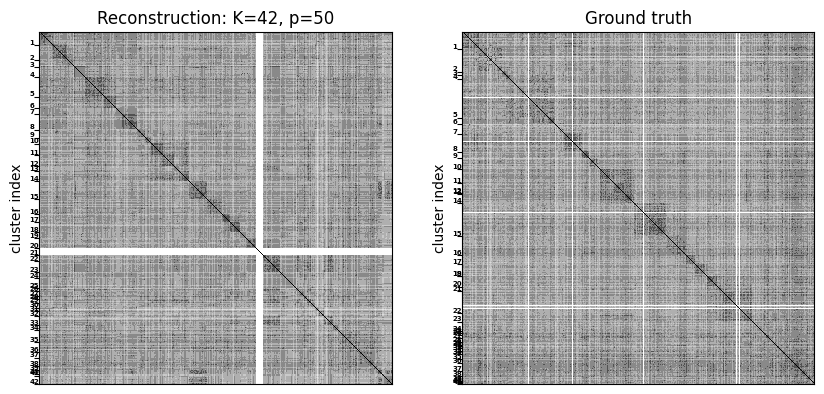

In [360]:

plt.figure(figsize=(10,20))    

plt.subplot(121)
idx = np.argsort(matched)
PMAT_rec = CSE.D[idx, :][:, idx]
plt.matshow(PMAT_rec, cmap=plt.cm.gray, fignum=False)
plt.xticks([])
plt.yticks(np.concatenate((np.where((matched[idx] - np.roll(matched[idx], 1)) > 0)[0],[NUM_NODES])), labels=np.arange(1,43), va='bottom', ha='left')
plt.yticks(fontsize=5, fontweight='bold')
plt.ylabel('cluster index')
plt.title(f'Reconstruction: K={K}, p={p_opt}')  

## Here you can provide plots and calculations
jdx = np.argsort(AFFILIATIONS)
PMAT_org = CSE.D[jdx, :][:, jdx]
plt.subplot(122)
plt.matshow(PMAT_org, cmap=plt.cm.gray, fignum=False)
plt.xticks([])
plt.yticks(np.concatenate((np.where((AFFILIATIONS[jdx] - np.roll(AFFILIATIONS[jdx], 1)) > 0)[0],[NUM_NODES])), labels=np.arange(1,43), va='bottom', ha='left')
plt.yticks(fontsize=5, fontweight='bold')
plt.ylabel('cluster index')
plt.title('Ground truth')
plt.show()  

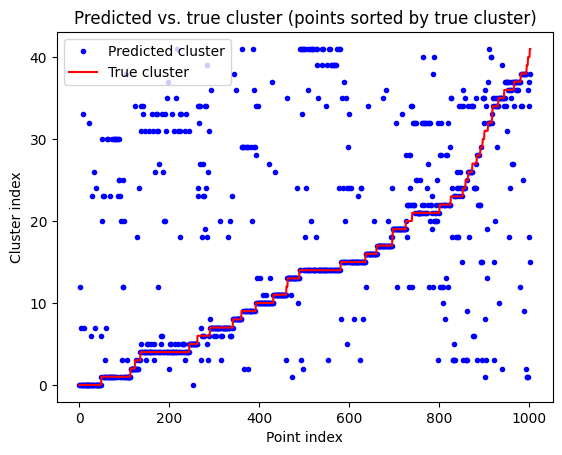

Accuracy:  0.57


In [358]:
jdx = np.argsort(AFFILIATIONS)
true = AFFILIATIONS[jdx]
pred = matched[jdx]
plt.plot(np.arange(0, len(pred)), pred, 'b.')
plt.plot(np.arange(0, len(true)), true, 'r-')
plt.legend(['Predicted cluster', 'True cluster'])
plt.ylabel('Cluster index')
plt.xlabel('Point index')
plt.title('Predicted vs. true cluster (points sorted by true cluster)')
plt.show()
acc = accuracy_score(true, pred)
print("Accuracy: ", round(acc, 3))

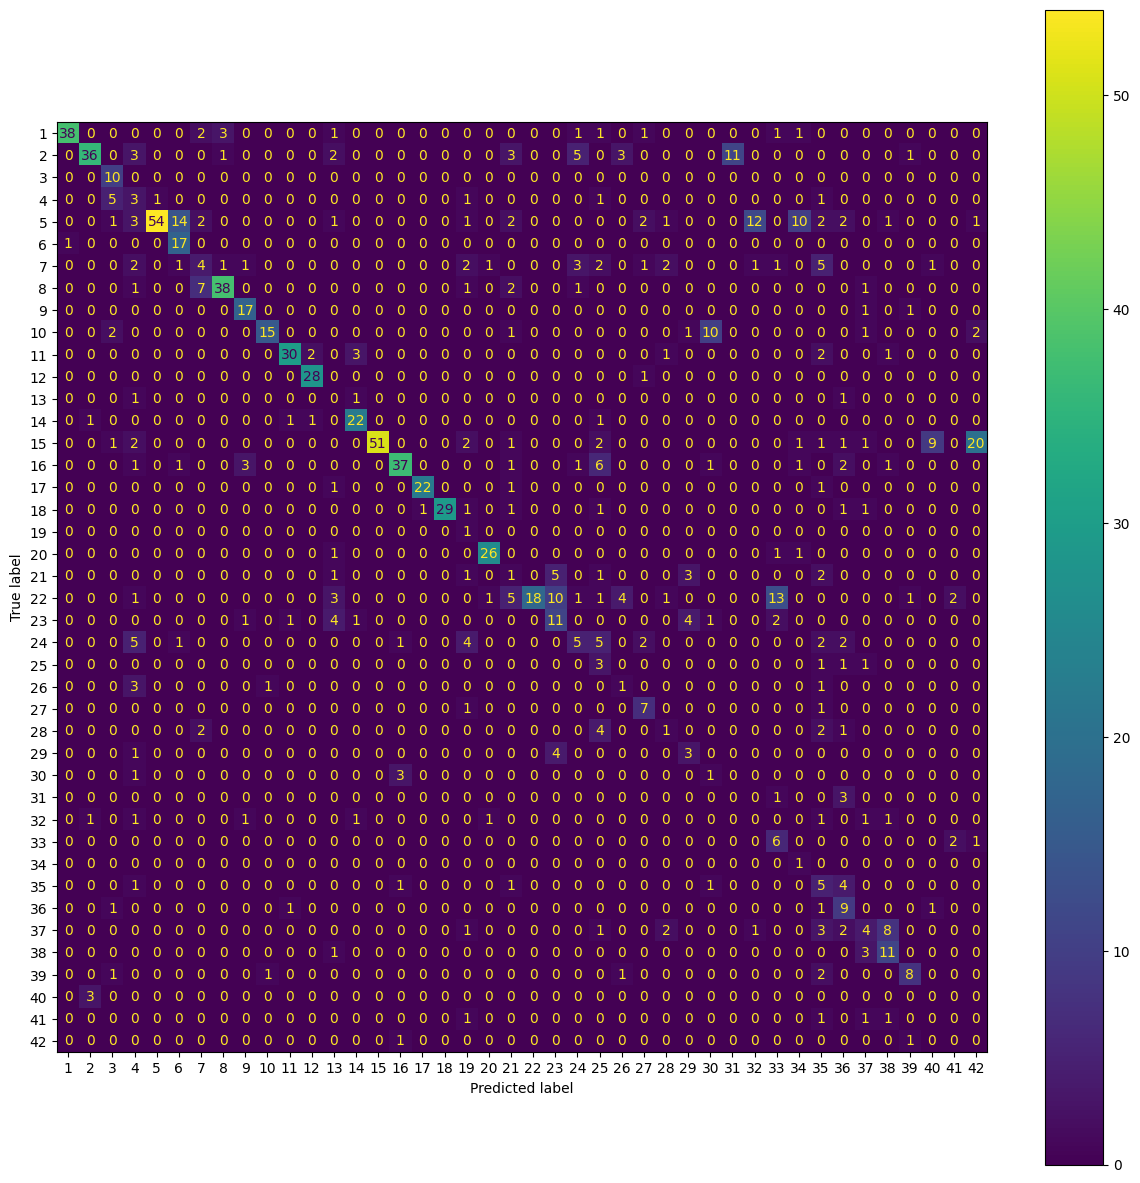

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=np.arange(1,43)) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

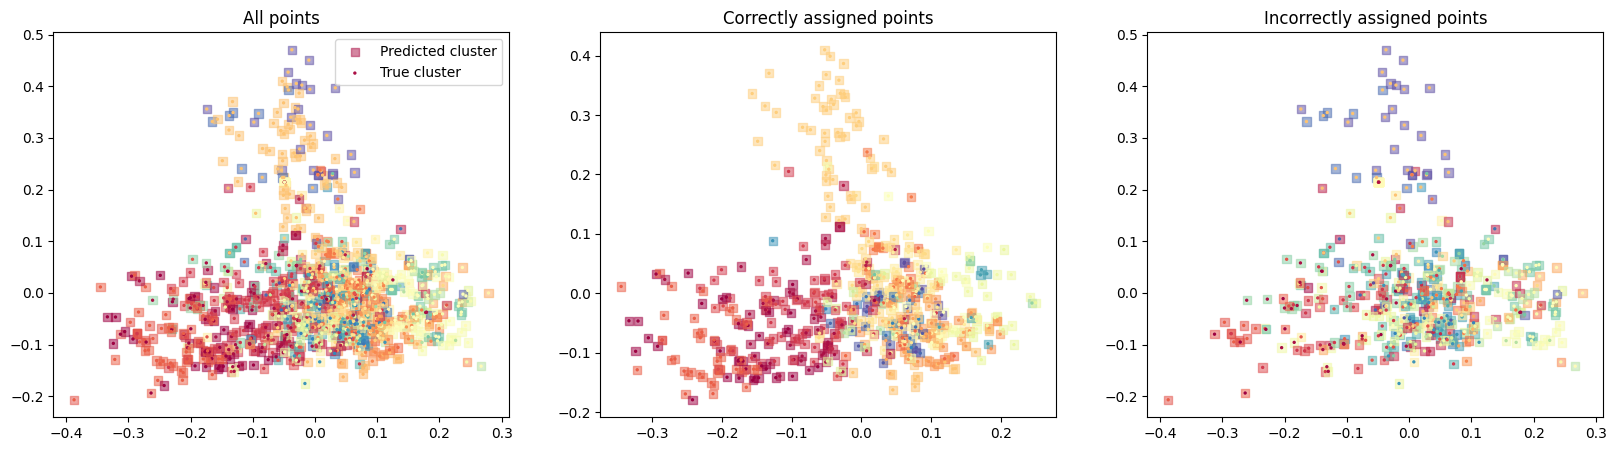

In [336]:
import matplotlib as mpl

p = 2
Xp = CSE.get_embedded_vectors(p)


K = 42
    
KM = KMeans(n_clusters=K, n_init=10, random_state=42)
clusters = KM.fit_predict(Xp)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(Xp[:, 0], Xp[:,1], marker='s', c=matched, cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[:, 0], Xp[:,1], marker='.', s=8, c=AFFILIATIONS, cmap=CMAP42)
plt.legend(['Predicted cluster', 'True cluster'])
plt.title("All points")

plt.subplot(132)
idx = matched == AFFILIATIONS
plt.plt.scatter(Xp[idx, 0], Xp[idx,1], marker='s', c=matched[idx], cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[idx, 0], Xp[idx,1], marker='.', s=8, c=AFFILIATIONS[idx], cmap=CMAP42)
plt.title("Correctly assigned points")

plt.subplot(133)
idx = matched != AFFILIATIONS
plt.plt.scatter(Xp[idx, 0], Xp[idx,1], marker='s', c=matched[idx], cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[idx, 0], Xp[idx,1], marker='.', s=8, c=AFFILIATIONS[idx], cmap=CMAP42)
plt.title("Incorrectly assigned points")

plt.show()

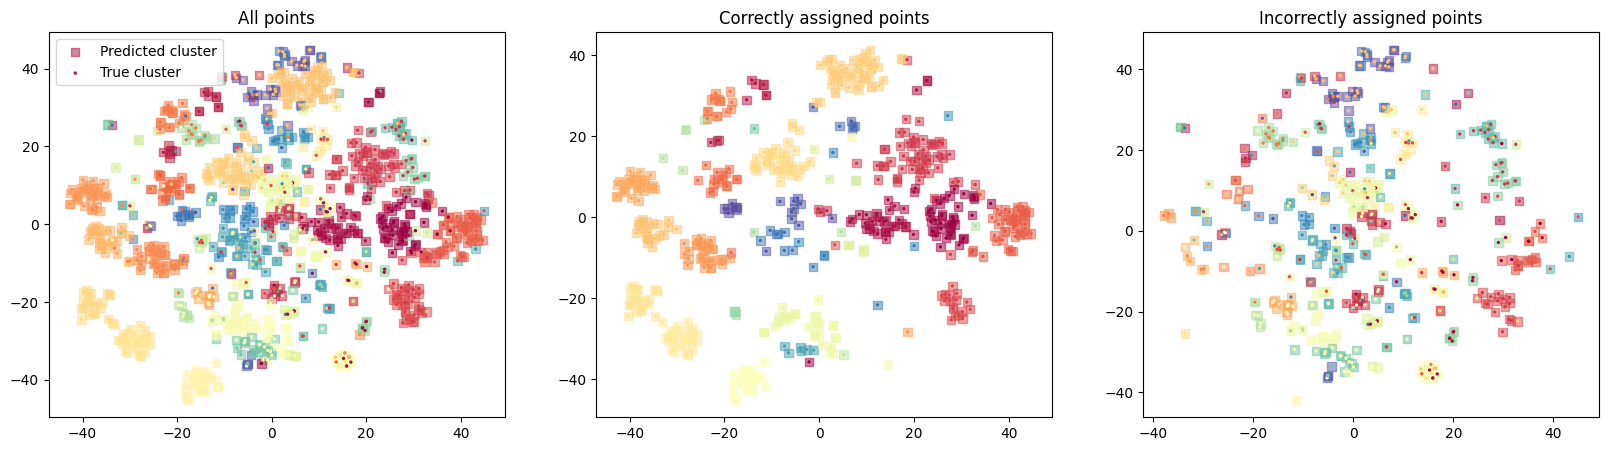

In [362]:
Xp = CSE.get_embedded_vectors(p_opt)

Xp = TSNE(n_components=2).fit_transform(Xp)

K = 42
    
KM = KMeans(n_clusters=K, n_init=10, random_state=42)
clusters = KM.fit_predict(Xp) 

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(Xp[:, 0], Xp[:,1], marker='s', c=matched, cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[:, 0], Xp[:,1], marker='.', s=8, c=AFFILIATIONS, cmap=CMAP42)
plt.legend(['Predicted cluster', 'True cluster'])
plt.title("All points")

plt.subplot(132)
idx = matched == AFFILIATIONS
plt.plt.scatter(Xp[idx, 0], Xp[idx,1], marker='s', c=matched[idx], cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[idx, 0], Xp[idx,1], marker='.', s=8, c=AFFILIATIONS[idx], cmap=CMAP42)
plt.title("Correctly assigned points")

plt.subplot(133)
idx = matched != AFFILIATIONS
plt.plt.scatter(Xp[idx, 0], Xp[idx,1], marker='s', c=matched[idx], cmap=CMAP42, alpha=0.5)
plt.scatter(Xp[idx, 0], Xp[idx,1], marker='.', s=8, c=AFFILIATIONS[idx], cmap=CMAP42)
plt.title("Incorrectly assigned points")
plt.show()

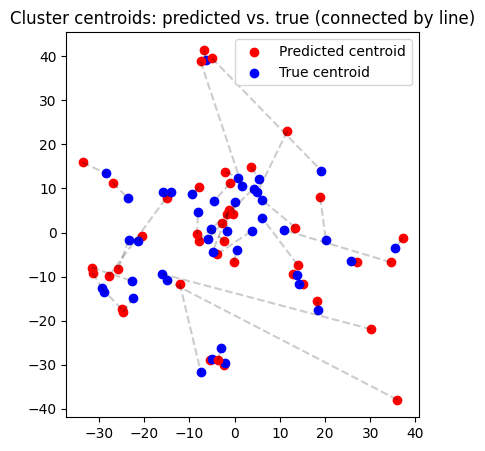

In [366]:
import matplotlib.colors as mcolors


Xp = CSE.get_embedded_vectors(p_opt)

K = 42
colors = list(mcolors.CSS4_COLORS.values())
    
plt.figure(figsize=(10,5))
KM = KMeans(n_clusters=K, n_init=10, random_state=42)
clusters = KM.fit_predict(Xp) 

plt.subplot(121)
for k in range(K):
    centroid_pred = np.average(X2[np.where(matched==k)[0],:], axis=0)
    centroid_true = np.average(X2[np.where(AFFILIATIONS==k)[0],:], axis=0)
    centroids = np.array([centroid_pred, centroid_true])
    plt.scatter(centroid_pred[0], centroid_pred[1], c='r')
    plt.scatter(centroid_true[0], centroid_true[1], c='b')
    plt.legend(["Predicted centroid", "True centroid"])
    plt.plot(centroids[:,0], centroids[:,1], '--', alpha=0.2, c='k')
plt.title(f'Cluster centroids: predicted vs. true (connected by line)')
plt.show()

We calculated the model accuracy and found that the model classies 57% of the points correctly, which is a lot considering the large amount of clusters. We also plotted the points against their cluster index, when sorted according to their correct cluster. We see in this plot that the predicted clusters overlap quite a lot with the true clusters. Furthermore, we visualized the confusion matrix of predicted clusters against actual clusters, which shows that model predicts correctly for a large portion of the bigger clusters. Moreover, the 2-dimensional embedding was plotted (both using $p=2$ and using TSNE with $p = p^*$), and the true as well as predicted cluster was indicated. This visualisation once again shows that the prediction is successful, and that many of the incorrectly classified points lie at intersections of clusters, thus making them hard to predict. Lastly, we plotted the centroids of predicted, as well as true, clusters. Even though some of the predicted centroids do not agree well with the true centroids, most centroid pairs correspond well.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.